In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
PATH = '/content/gdrive/MyDrive/Thesis/LSST/'

In [ ]:
import glob
import pandas as pd
import numpy as np


import tensorflow as tf
import keras
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, Conv2D, Conv1D, BatchNormalization, ELU, Reshape, concatenate, ReLU
from tensorflow.keras.layers import Dropout, MaxPooling2D, MaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D, Permute


In [ ]:
def add_missing_values(data, stride=1, sparcity = 0.02, fill_method = 'zero'):
    
    shape = data.shape
    size = shape[0]*shape[1]
    
    mask = np.zeros(size, dtype=int)
    mask[:int(size*sparcity/stride)] = 1
    np.random.shuffle(mask)
    
    mask = mask.reshape(shape)
    mask_orig = mask.copy()
    for step in range(1,stride):
        mask = mask + np.hstack((np.zeros((shape[0], step)), mask_orig[:, :-step]))
        
    mx = np.ma.masked_array(data, mask=mask)
    
    if fill_method == 'zero':
        mx = mx.filled(0)
    if fill_method == 'forw_fill':
        
        df = pd.DataFrame(mx)
        df.fillna(method='ffill', axis=1, inplace=True)
        df.fillna(method='bfill', axis=1, inplace=True)
        mx = df.to_numpy()
    if fill_method == 'mean':
        mx = mx.filled(np.mean(mx))
    
    return mx, mask

In [ ]:
train = glob.glob(PATH + 'LSSTDimension*_TRAIN.arff')
test = glob.glob(PATH + 'LSSTDimension*_TEST.arff')

In [ ]:
columns = [f't{t}' for t in range(1, 37)]
columns.append('class')
train_data = [pd.read_csv(file, skiprows=41, names=columns) for file in train]
test_data = [pd.read_csv(file, skiprows=41, names=columns) for file in test]


In [33]:
def code_to_ranks(labels):
    labels = list(set(labels))
    labels.sort()
    
    encoding = {key: value for value, key in enumerate(labels)}
    
    return encoding

def standard_scaling(data_3dim):
    #Observations, attributes, TS  length
    scaled = (data_3dim - np.mean(data_3dim, axis=2, keepdims=True)) /  \
                                np.std(data_3dim, axis=2, keepdims=True)
    
    return scaled


train = np.stack(train_data, axis=2)
train = np.swapaxes(train, 1,2)
train_labels = train[:,1,-1]
train = train[:,:,:-1]
train = standard_scaling(train)


train_with_miss = [add_missing_values(obs, fill_method='mean', sparcity = 0.02) for obs in train]
train_with_miss_no_ind = [np.stack((v)) for v, m in train_with_miss]
train_with_miss = [np.transpose(np.stack((v, m)), axes=(1,2,0)) for v, m in train_with_miss]


train_with_miss = np.array(train_with_miss)
train_with_miss_no_ind = np.array(train_with_miss_no_ind)




enc = code_to_ranks(train_labels)
train_labels = np.array([enc[l] for l in train_labels]).reshape(-1,1)
train_labels = train_labels.astype(int)

test = np.stack(test_data, axis=2)
test = np.swapaxes(test, 1,2)
test_labels = test[:,1,-1]
test_labels = np.array([enc[l] for l in test_labels]).reshape(-1,1)
test_labels= test_labels.astype(int)
test = test[:,:,:-1]
test = standard_scaling(test)

test_with_miss = [add_missing_values(obs, fill_method='mean', sparcity = 0.02) for obs in test]
test_with_miss_no_ind = [np.stack((v)) for v, m in test_with_miss]
test_with_miss = [np.transpose(np.stack((v, m)), axes=(1,2,0)) for v, m in test_with_miss]

test_with_miss = np.array(test_with_miss) 

test_with_miss_no_ind = np.array(test_with_miss_no_ind)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [34]:
pd.DataFrame(data=train[0,:,:].T).describe()

0             1             2             3             4  \
count  3.600000e+01  3.600000e+01  3.600000e+01  3.600000e+01  3.600000e+01   
mean   2.390063e-17  4.934325e-17  7.401487e-17  1.233581e-17 -3.083953e-17   
std    1.014185e+00  1.014185e+00  1.014185e+00  1.014185e+00  1.014185e+00   
min   -8.632082e-01 -7.903118e-01 -2.028510e+00 -3.510104e-01 -4.209063e-01   
25%   -5.566063e-01 -3.248930e-01 -6.998664e-01 -2.767302e-01 -3.913763e-01   
50%   -3.845465e-01 -2.691826e-01  2.997545e-02 -2.635024e-01 -3.807587e-01   
75%   -7.856406e-02 -1.737917e-01  6.086679e-01 -2.525820e-01 -2.917635e-01   
max    2.897227e+00  4.421534e+00  2.090960e+00  4.708975e+00  3.857914e+00   

                  5  
count  3.600000e+01  
mean  -2.467162e-17  
std    1.014185e+00  
min   -8.851323e-01  
25%   -3.923393e-01  
50%   -2.217008e-01  
75%    3.955504e-03  
max    4.500213e+00

In [35]:

def lsst_model(input_shape, num_classes):
    
    X_input = Input(shape=input_shape)

 	# Temporal Convolutions
    conv1 = Conv2D(64, (1, 1), strides=1, padding="same", kernel_initializer='he_uniform')(X_input)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU(alpha=1.0)(conv1)
    # conv1 = ReLU()(conv1)
    conv1 = Permute((3,2,1))(conv1)
    
    conv1 = Conv2D(32, (1, 3), strides=1, padding="same", kernel_initializer='he_uniform')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU(alpha=1.0)(conv1)
    # conv1 = ReLU()(conv1)
    conv1 = Permute((3,2,1))(conv1)
    
    conv2 = Conv2D(64, (1, 4), strides=1, padding="same", kernel_initializer='he_uniform')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU(alpha=1.0)(conv2)
    # conv2 = ReLU()(conv2)
    conv2 = Permute((3,2,1))(conv2)
    
    conv2 = Conv2D(32, (1, 3), strides=1, padding="same", kernel_initializer='he_uniform')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU(alpha=1.0)(conv2)
    # conv2 = ReLU()(conv2)
    conv2 = Permute((3,2,1))(conv2)

    conv3 = Conv2D(64, (1, 4), strides=1, padding="same", kernel_initializer='he_uniform')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU(alpha=1.0)(conv3)
    # conv3 = ReLU()(conv3)
    conv3 = Permute((3,2,1))(conv3)
    
    conv3 = Conv2D(32, (1, 3), strides=1, padding="same", kernel_initializer='he_uniform')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU(alpha=1.0)(conv3)
    # conv3 = ReLU()(conv3)

    conv4 = Conv2D(32, (1, 4), strides=1, padding="same", kernel_initializer='he_uniform')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU(alpha=1.0)(conv4)
    # conv4 = ReLU()(conv4)
    conv4 = Permute((3,2,1))(conv4)
    
    conv4 = Conv2D(16, (1, 3), strides=1, padding="same", kernel_initializer='he_uniform')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU(alpha=1.0)(conv4)
    # conv4 = ReLU()(conv4)
  


    
    
    # MaxPool = MaxPooling2D(pool_size=(5, 1), strides=None, padding='same')(conv4)
    # conv4 = Dropout(0.4)(conv4)
    gap_DCNN = GlobalAveragePooling2D()(conv4)
    gap_DCNN = Dropout(0.5)(gap_DCNN)
    
    output_layer = tf.keras.layers.Dense(num_classes)(gap_DCNN)
    model = tf.keras.models.Model(inputs=X_input, outputs=output_layer)
    
    
    return model
    
    
m = lsst_model((6,36,2), 14)
m.summary()


Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 6, 36, 2)]        0         
                                                                 
 conv2d_128 (Conv2D)         (None, 6, 36, 64)         192       
                                                                 
 batch_normalization_128 (Ba  (None, 6, 36, 64)        256       
 tchNormalization)                                               
                                                                 
 elu_128 (ELU)               (None, 6, 36, 64)         0         
                                                                 
 permute_96 (Permute)        (None, 64, 36, 6)         0         
                                                                 
 conv2d_129 (Conv2D)         (None, 64, 36, 32)        608       
                                                          

Epoch 1/500
15/15 [==============================] - 3s 108ms/step - loss: 2.6158 - accuracy: 0.0911 - val_loss: 3.8582 - val_accuracy: 0.0748 - lr: 0.0010
Epoch 2/500
15/15 [==============================] - 1s 87ms/step - loss: 2.3391 - accuracy: 0.2565 - val_loss: 4.3586 - val_accuracy: 0.1382 - lr: 0.0010
Epoch 3/500
15/15 [==============================] - 1s 88ms/step - loss: 2.1668 - accuracy: 0.3351 - val_loss: 4.7081 - val_accuracy: 0.1268 - lr: 0.0010
Epoch 4/500
15/15 [==============================] - 1s 87ms/step - loss: 2.0418 - accuracy: 0.3888 - val_loss: 4.0679 - val_accuracy: 0.1447 - lr: 0.0010
Epoch 5/500
15/15 [==============================] - 1s 88ms/step - loss: 1.9440 - accuracy: 0.4214 - val_loss: 3.4076 - val_accuracy: 0.1821 - lr: 0.0010
Epoch 6/500
15/15 [==============================] - 1s 88ms/step - loss: 1.8668 - accuracy: 0.4572 - val_loss: 3.1185 - val_accuracy: 0.2228 - lr: 0.0010
Epoch 7/500
15/15 [==============================] - 1s 88ms/step - l

[nan, 0.455798864364624]

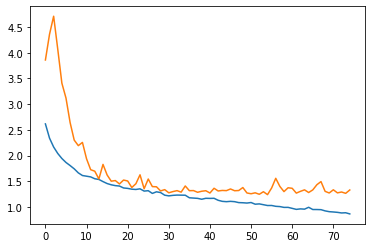

In [42]:
tf.debugging.set_log_device_placement(True)

X_train, X_val, y_train, y_val = train_test_split(train_with_miss_no_ind, train_labels, test_size=0.25, random_state=147)


model = lsst_model(input_shape = (6,36,1), num_classes = 14)
# model = lsst_model(input_shape = (6,36,2), num_classes = 14)



loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.9)

model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001),
              loss=loss,
              metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=20, min_lr=0.0001)

loss_hist = model.fit(X_train, y_train, epochs=500,
                       batch_size=128,
                       validation_data=(X_val, y_val),
                       callbacks=[reduce_lr,
                                  tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                mode='auto',
                                                verbose=0,
                                                patience=20,
                                                restore_best_weights=True)
                                  ]
                       )


import matplotlib.pyplot as plt

plt.plot(loss_hist.history['loss'])
plt.plot(loss_hist.history['val_loss'])


model.evaluate(test_with_miss_no_ind,  test_labels, verbose=2)

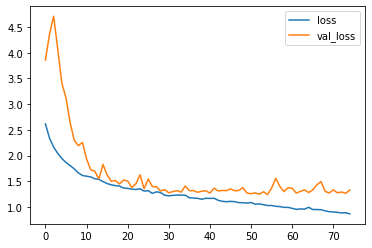

In [43]:

plt.plot(loss_hist.history['loss'], label = 'loss')
plt.plot(loss_hist.history['val_loss'], label  = 'val_loss')
plt.legend()
plt.show()



plt.plot(loss_hist.history['accuracy'], label = 'accuracy')
plt.plot(loss_hist.history['val_accuracy'], label  = 'val_accuracy')
plt.legend()
plt.show()




In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
model.save((PATH + 'model1'))

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Thesis/LSST/model1/assets


image.png